#  Detect diabetic retinopathy to stop blindness before it's too late

## https://www.kaggle.com/c/aptos2019-blindness-detection
Millions of people suffer from diabetic retinopathy, the leading cause of blindness among working aged adults. Aravind Eye Hospital in India hopes to detect and prevent this disease among people living in rural areas where medical screening is difficult to conduct.

Currently, Aravind technicians travel to these rural areas to capture images and then rely on highly trained doctors to review the images and provide diagnosis. Their goal is to scale their efforts through technology; to gain the ability to automatically screen images for disease and provide information on how severe the condition may be.


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from copy import deepcopy

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

In [0]:
import os
print(os.listdir("../input"))

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2  # for image processing
import scipy.io
import os
#import keras_utils
#from keras_utils import reset_tf_session 
print(tf.__version__)
print(keras.__version__)

1.14.0
2.2.4


Using TensorFlow backend.


In [0]:
plt.rcParams.update({'axes.titlesize': 'small'})

In [0]:
IMG_SIZE = 64

In [0]:
import glob, pandas as pd

In [0]:
!ls ../input/

sample_submission.csv  test.csv  test_images  train.csv  train_images


## Data set description

provided with a large set of retina images taken using fundus photography under a variety of imaging conditions.

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. The images were gathered from multiple clinics using a variety of cameras over an extended period of time, which will introduce further variation.

In [0]:
pd.read_csv("../input/train.csv").head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [0]:
labels_df = pd.read_csv("../input/train.csv").set_index('id_code')

In [0]:
len(labels_df.index)

3662

### Distribution of various labels 

In [0]:
labels_df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [0]:
images = [f for f in glob.glob("../input/train_images/" + "*.png")]
labels = [ labels_df.loc[f.split('/')[-1].split('.')[0].strip()].diagnosis for f in  images]

In [0]:
train_images_ixs = set(random.choices(range(len(images)), k=6000))
train_images = []
train_labels = []
test_images = []
test_labels = []
for i in range(len(labels)):
    if i in train_images_ixs:
        train_images.append(images[i])
        train_labels.append(labels[i])
    else:
        test_images.append(images[i])
        test_labels.append(labels[i])

In [0]:
#print (train_images_ixs)
print (len(train_labels), len(train_images))
print (len(test_labels), len(test_images))

2953 2953
709 709


In [0]:
#test_labels_df = pd.read_csv("../input/test.csv").set_index('id_code')

In [0]:
for img,lb in zip(images[:5], labels[:5]):
    print (img, lb)

../input/train_images/f549294e12e1.png 4
../input/train_images/86d58f850a0c.png 0
../input/train_images/6e1db8711879.png 0
../input/train_images/ce8d2efd9d4f.png 0
../input/train_images/3e1f8fecb06f.png 2


In [0]:
from PIL import Image
from matplotlib import pyplot as plt
import random

In [0]:
label_text = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

## Plotting images of the samples at different levels of criticality of  diabetic retinopathy

*  row 1 : No DR categoery
*  row 2 : Mild category Samples
*  row 4 : Moderate DR categoery Samples
*  row 5 : Proliferative DR category Samples 

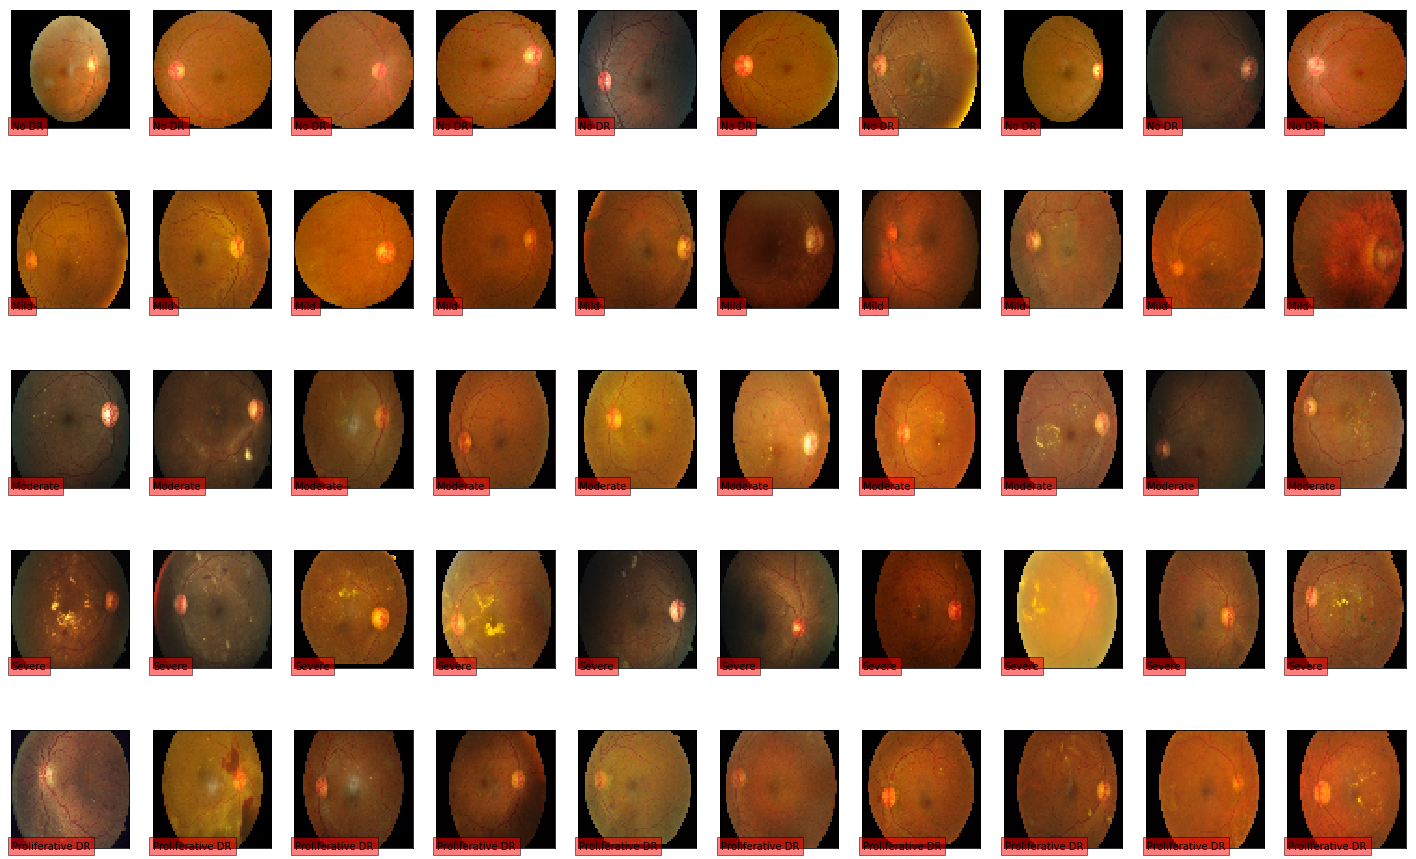

In [0]:
images_to_display = []
for lb in range(5):
    images_to_display += random.choices([ (images[ix], labels[ix]) for ix in range(len(images)) if labels[ix] == lb ] , k=10)

fig = plt.figure(figsize=(25, 16))
for ii, (img,label) in enumerate(images_to_display):
    ax = fig.add_subplot(5, 10, ii + 1, xticks=[], yticks=[])
    img = cv2.imread(img)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = Image.open(img_byte)
    plt.imshow(img)
    plt.text(0, img.shape[0], label_text[label], bbox=dict(facecolor='red', alpha=0.5))

## some modifications on the image to enhance the feature extraction
* Gamma adjustment: adjusting the brightness of the image
* add contrast to the image
* preprocess image impliments these transformations

In [0]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [0]:
def add_contrast(img, contrast):
        buf = img.copy()
        f = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
        return buf

In [0]:
def preproces_image(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = adjust_gamma(img, 1.5)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = add_contrast(img, 20)
    #laplacian = cv2.Laplacian(img,cv2.CV_64F)
    #sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    #sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    return img
    

# display samples in Grid

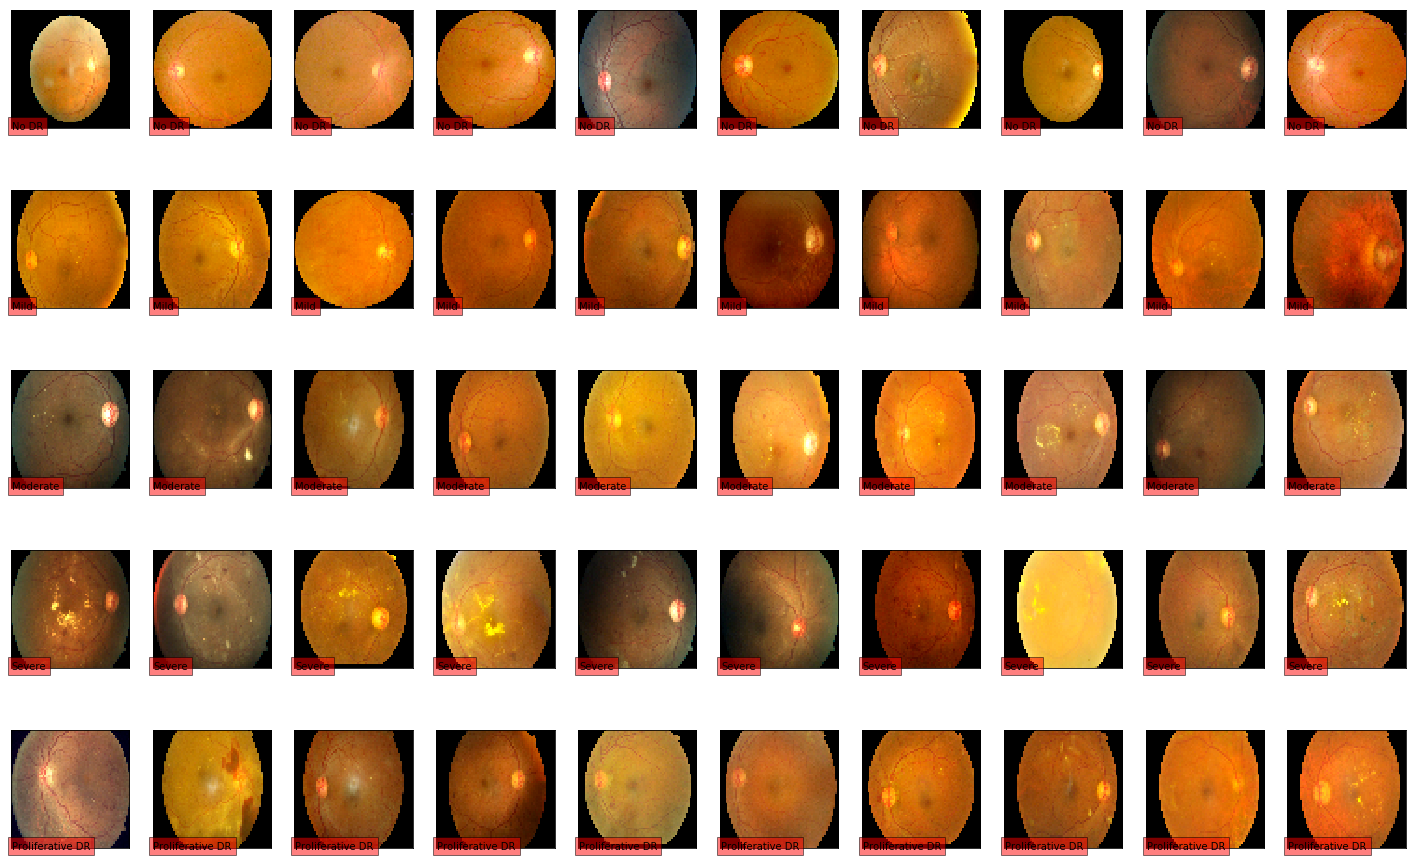

In [0]:
fig = plt.figure(figsize=(25, 16))
for ii, (img,label) in enumerate(images_to_display):
    ax = fig.add_subplot(5, 10, ii + 1, xticks=[], yticks=[])
    img = cv2.imread(img)
    img_new = preproces_image(img)
    #print (img.shape)
    #img = Image.open(img_byte)
    plt.imshow(img_new)
    plt.text(0, img_new.shape[0], label_text[label], bbox=dict(facecolor='red', alpha=0.5))

In [0]:
def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-180, 180)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

## Assign weights to samlples based on the class distribution to handle the baised  dataset

In [0]:
wts = [0.1, 0.4, 0.2 , 0.90, 0.60]

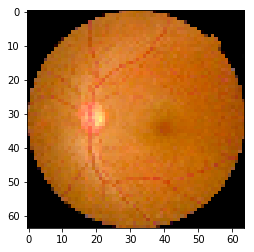

In [0]:
img = cv2.imread(train_images[0])
img = preproces_image(img)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE) )
plt.imshow(img)

In [0]:
num_of_class = 5

In [0]:
def generate_training_images(cur_images, cur_tags, batch_size=500):
    cur_batch = []
    cur_labels = []
    cur_wts = []
    for ix,image in enumerate(cur_images):
        #print (ix,len(cur_labels))
        label = cur_tags[ix]
        wt = wts[label]
        img = cv2.imread(image)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = adjust_gamma(img, 1.5)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = add_contrast(img, 20)
        #img = preproces_image(img)
        #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        new_img = deepcopy(img)
        #new_img += cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY) 
        cur_batch.append(new_img)
        cur_labels.append(label)
        cur_wts.append(wt)
        if len(cur_batch) == batch_size:
            batch_imgs = np.stack(cur_batch, axis=0)
            batch_targets = keras.utils.np_utils.to_categorical(cur_labels, num_of_class )
            yield batch_imgs,batch_targets, np.array(cur_wts)
            cur_batch = []
            cur_labels = []
            cur_wts = []


        new_img = adjust_gamma(deepcopy(img), random.uniform(0.8, 1.8))
        #new_img += cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY) 
        cur_batch.append(new_img)
        cur_labels.append(label)
        cur_wts.append(wt)
        if len(cur_batch) == batch_size:
            batch_imgs = np.stack(cur_batch, axis=0)
            batch_targets = keras.utils.np_utils.to_categorical(cur_labels, num_of_class)
            yield batch_imgs,batch_targets, np.array(cur_wts)
            cur_batch = []
            cur_labels = []
            cur_wts = []
        
        new_img = horizontal_flip(deepcopy(img))
        #new_img += cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY) 
        cur_batch.append(new_img)
        cur_labels.append(label)
        cur_wts.append(wt)
        if len(cur_batch) == batch_size:
            batch_imgs = np.stack(cur_batch, axis=0)
            batch_targets = keras.utils.np_utils.to_categorical(cur_labels, num_of_class)
            yield batch_imgs,batch_targets, np.array(cur_wts)
            cur_batch = []
            cur_labels = []
            cur_wts = []
    batch_imgs = np.stack(cur_batch, axis=0)
    batch_targets = keras.utils.np_utils.to_categorical(cur_labels, num_of_class )
    yield batch_imgs,batch_targets,  np.array(cur_wts)

In [0]:
def generate_testing_images(cur_images, cur_tags, batch_size=500):
    while True:
        cur_batch = []
        cur_labels = []
        cur_wts = []
        for ix,image in enumerate(cur_images):
            #print (ix,len(cur_labels))
            label = cur_tags[ix]
            wt = wts[label]
            img = cv2.imread(image)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = adjust_gamma(img, 1.5)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = add_contrast(img, 20)
            #img = preproces_image(img)
            #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            new_img = deepcopy(img)
            #new_img += cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY) 
            cur_batch.append(new_img)
            cur_labels.append(label)
            cur_wts.append(wt)
            if len(cur_batch) == batch_size:
                batch_imgs = np.stack(cur_batch, axis=0)
                batch_targets = keras.utils.np_utils.to_categorical(cur_labels, num_of_class )
                yield batch_imgs,batch_targets
                cur_batch = []
                cur_labels = []
                cur_wts = []


            new_img = adjust_gamma(deepcopy(img), random.uniform(0.8, 1.8))
            #new_img += cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY) 
            cur_batch.append(new_img)
            cur_labels.append(label)
            cur_wts.append(wt)
            if len(cur_batch) == batch_size:
                batch_imgs = np.stack(cur_batch, axis=0)
                batch_targets = keras.utils.np_utils.to_categorical(cur_labels, num_of_class)
                yield batch_imgs,batch_targets
                cur_batch = []
                cur_labels = []
                cur_wts = []

            new_img = horizontal_flip(deepcopy(img))
            #new_img += cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY) 
            cur_batch.append(new_img)
            cur_labels.append(label)
            cur_wts.append(wt)
            if len(cur_batch) == batch_size:
                batch_imgs = np.stack(cur_batch, axis=0)
                batch_targets = keras.utils.np_utils.to_categorical(cur_labels, num_of_class)
                yield batch_imgs,batch_targets
                cur_batch = []
                cur_labels = []
                cur_wts = []
        batch_imgs = np.stack(cur_batch, axis=0)
        batch_targets = keras.utils.np_utils.to_categorical(cur_labels, num_of_class )
        yield batch_imgs,batch_targets

In [0]:
#train_images

In [0]:
print (len(train_images), len(train_labels))
train_labels[:1]

2953 2953


[0]

(64, 64, 3) 100


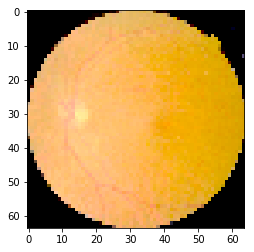

In [0]:
for batch in generate_training_images(train_images, train_labels, 100):
    tmp_images, labels, wts  = batch
    print (tmp_images[0].shape, len(labels) )
    plt.imshow(tmp_images[10])
    break

In [0]:
#plt.imshow(tmp_images[1])

In [0]:
 #plt.imshow(tmp_images[2])

In [0]:
from keras.applications.densenet import DenseNet121
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)

In [0]:
s = reset_tf_session()

In [0]:
img_in = Input(input_shape)              #input of model 
model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= input_shape,
                pooling ='avg') 

x = model.output  
predictions = Dense(num_of_class, activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model = Model(inputs=img_in, outputs=predictions)

29089792/29084464 [==============================] - 2s 0us/step


In [0]:
#model.summary()

In [0]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 200
EPOCHS = 100
def lr_scheduler(epoch):
    return min(INIT_LR * 0.9 ** epoch, 0.00001)

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))



In [0]:
from keras_tqdm import TQDMNotebookCallback

In [0]:
len(test_images)
len(test_labels)

709

In [0]:
# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)
model.fit_generator(epochs=EPOCHS,
                    generator=generate_training_images(train_images, train_labels, BATCH_SIZE),
                    steps_per_epoch = len(train_images) // BATCH_SIZE // 8,
                    validation_steps = 20,
                  callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
                               LrHistory(),
                               TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
                    validation_data=generate_testing_images(test_images, test_labels, BATCH_SIZE),
                    use_multiprocessing=True,
                    workers = 4,
                    initial_epoch=0)

Epoch 1/100
1/1 [==============================] - 131s 131s/step - loss: 0.1071 - acc: 0.7150 - val_loss: 2.7918 - val_acc: 0.5200
Epoch 2/100
1/1 [==============================] - 73s 73s/step - loss: 0.0989 - acc: 0.7300 - val_loss: 2.2164 - val_acc: 0.6345
Epoch 3/100


In [0]:
model.save("./iris_trained_model")